In [1]:
import time
t1 = time.time()

import math
import os
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam , SGD , Adagrad
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras import regularizers , initializers
from sklearn.metrics import confusion_matrix
import tensorflow.keras.backend as K
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

gpus = tf.config.experimental.list_physical_devices("GPU")
tf.config.set_visible_devices(gpus[1], "GPU")

2026-01-23 10:14:00.823208: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
##### load data #####

HLdata_path = "/root/data/mucollider/two_boosted/data_HLfeature.h5"
HLdata_file = h5py.File(HLdata_path, 'r')
print(HLdata_file.keys())

LLdata_path = "/root/data/mucollider/two_boosted/data_LLfeature.h5"
LLdata_file = h5py.File(LLdata_path, 'r')
print(LLdata_file.keys())

<KeysViewHDF5 ['BTag_leading', 'BTag_subleading', 'H_0', 'H_1', 'LB_1', 'M_JJ', 'S_0', 'S_1', 'X_HH', 'dEta_JJ', 'm_J_leading', 'm_J_subleading', 'missET', 'pT_JJ', 'pt_J_leading', 'pt_J_subleading', 'target_everytype', 'target_sigbg']>
<KeysViewHDF5 ['particle_info']>


In [3]:
##### include data #####

HLfeatures = ['BTag_leading', 'BTag_subleading', 'H_0', 'H_1', 'LB_1', 'M_JJ', 'S_0', 'S_1', 'X_HH', 'dEta_JJ', 'm_J_leading', 'm_J_subleading', 'missET', 'pT_JJ', 'pt_J_leading', 'pt_J_subleading']
LLfeatures = ['particle_info']

##### select BTag work point at WP70 (BitNumber 1) #####

BTag_leading = ((HLdata_file['BTag_leading'][:])&2)
BTag_subleading = ((HLdata_file['BTag_subleading'][:])&2)

##### include other high level features data #####

HLdata = []
for feature in HLfeatures:
    if feature=='BTag_leading': HLdata.append(BTag_leading)
    elif feature=='BTag_subleading': HLdata.append(BTag_subleading)
    else: HLdata.append(HLdata_file[feature][:])
HLdata = np.array(HLdata).T
print('shape of high level data:', HLdata.shape)

LLdata = LLdata_file['particle_info'][:]
print('shape of low level data:', LLdata.shape)

target = HLdata_file['target_sigbg'][:]
print('shape of target:', target.shape)

#### Do training data and validation data split #####

HL_train, HL_val, LL_train, LL_val, y_train, y_val = train_test_split(HLdata, LLdata, target, test_size=0.2, random_state=2330, shuffle=True)
print("\nAfter training validation data split:")
print("HL training data: ", HL_train.shape, "HL validation data: ", HL_val.shape)
print("LL training data: ", LL_train.shape, "LL validation data: ", LL_val.shape)
print("training target: ", y_train.shape, "validation target: ", y_val.shape)

shape of high level data: (733359, 16)
shape of low level data: (733359, 160)
shape of target: (733359,)

After training validation data split:
HL training data:  (586687, 16) HL validation data:  (146672, 16)
LL training data:  (586687, 160) LL validation data:  (146672, 160)
training target:  (586687,) validation target:  (146672,)


In [4]:
##### construct model #####

### high level features part ###

HL_input = layers.Input(shape=(16,), name='HL_Input')

x_hl = layers.Dense(128)(HL_input)
x_hl = layers.BatchNormalization()(x_hl)
x_hl = layers.Activation('relu')(x_hl)
x_hl = layers.Dropout(0.1)(x_hl)

x_hl = layers.Dense(128)(x_hl)
x_hl = layers.BatchNormalization()(x_hl)
x_hl = layers.Activation('relu')(x_hl)
x_hl = layers.Dropout(0.1)(x_hl)

### low level features part ###

LL_input = layers.Input(shape=(160,), name='LL_Input')

x_ll = layers.Dense(512)(LL_input)
x_ll = layers.BatchNormalization()(x_ll)
x_ll = layers.Activation('relu')(x_ll)
x_ll = layers.Dropout(0.1)(x_ll)

x_ll = layers.Dense(128)(x_ll)
x_ll = layers.BatchNormalization()(x_ll)
x_ll = layers.Activation('relu')(x_ll)
x_ll = layers.Dropout(0.1)(x_ll)

### combine two parts of model and the following node ###

combined = layers.Concatenate()([x_hl, x_ll])

x = layers.Dense(256, activation='relu')(combined)
x = layers.Dense(16, activation='relu')(x)
output = layers.Dense(1, activation='sigmoid', name='Output')(x)

model = models.Model(inputs=[HL_input, LL_input], outputs=output)

### optimizer ###

opt = keras.optimizers.Adam(learning_rate=1e-5)

### compile ###

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy","mse"])

### summary ###

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 HL_Input (InputLayer)       [(None, 16)]                 0         []                            
                                                                                                  
 LL_Input (InputLayer)       [(None, 160)]                0         []                            
                                                                                                  
 dense (Dense)               (None, 128)                  2176      ['HL_Input[0][0]']            
                                                                                                  
 dense_2 (Dense)             (None, 512)                  82432     ['LL_Input[0][0]']            
                                                                                              

2026-01-23 10:14:04.040564: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46696 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:25:00.0, compute capability: 8.6


In [5]:
##### training model #####

tr_model = model.fit(x=[HL_train, LL_train], y=y_train, validation_data=([HL_val, LL_val], y_val), epochs=128, batch_size=256, verbose=1)

Epoch 1/128


2026-01-23 10:14:07.607946: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2026-01-23 10:14:07.614857: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x560292211da0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-01-23 10:14:07.614916: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2026-01-23 10:14:07.624194: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-01-23 10:14:07.764857: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2026-01-23 10:14:07.884504: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.

2292/2292 [==============================] - 24s 8ms/step - loss: 0.3610 - accuracy: 0.8353 - mse: 0.1152 - val_loss: 0.1792 - val_accuracy: 0.9343 - val_mse: 0.0510
Epoch 2/128
2292/2292 [==============================] - 19s 8ms/step - loss: 0.1828 - accuracy: 0.9284 - mse: 0.0536 - val_loss: 0.1234 - val_accuracy: 0.9563 - val_mse: 0.0342
Epoch 3/128
2292/2292 [==============================] - 19s 8ms/step - loss: 0.1536 - accuracy: 0.9410 - mse: 0.0443 - val_loss: 0.1126 - val_accuracy: 0.9604 - val_mse: 0.0309
Epoch 4/128
2292/2292 [==============================] - 19s 8ms/step - loss: 0.1388 - accuracy: 0.9475 - mse: 0.0396 - val_loss: 0.1053 - val_accuracy: 0.9631 - val_mse: 0.0288
Epoch 5/128
2292/2292 [==============================] - 19s 8ms/step - loss: 0.1275 - accuracy: 0.9524 - mse: 0.0361 - val_loss: 0.0988 - val_accuracy: 0.9654 - val_mse: 0.0271
Epoch 6/128
2292/2292 [==============================] - 19s 8ms/step - loss: 0.1184 - accuracy: 0.9563 - mse: 0.0334 - va

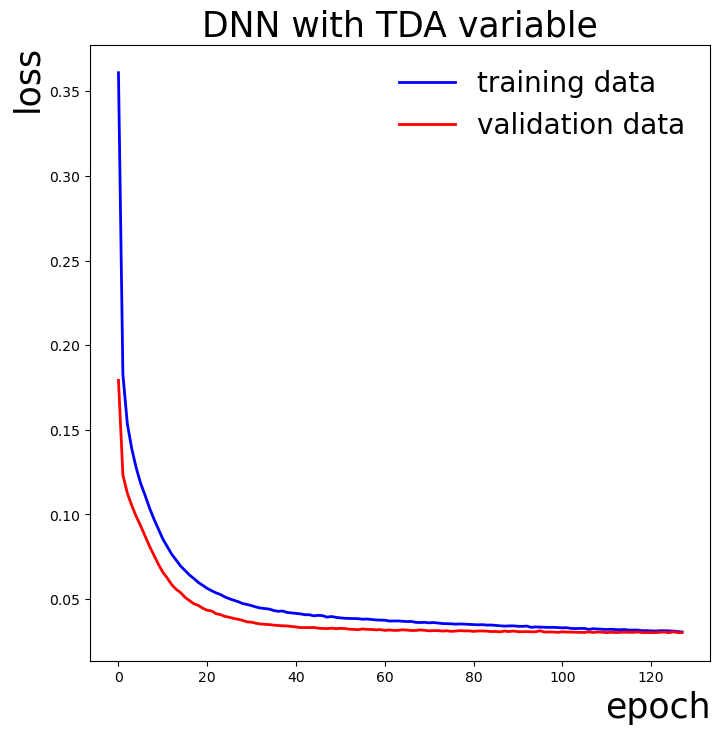

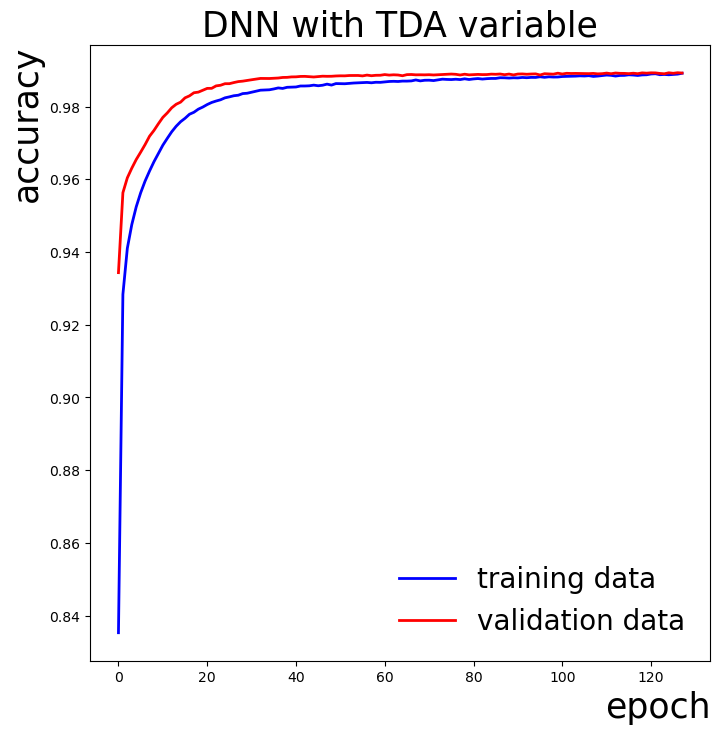

In [6]:
### plot learning curve

fig, ax = plt.subplots(1,1, figsize=(8,8))
plt.plot(tr_model.history["loss"], label='training data',c='blue',linewidth = 2)
plt.plot(tr_model.history["val_loss"], label='validation data',c='red',linewidth = 2)
plt.title("DNN with TDA variable", fontsize=25)
ax.set_ylabel('loss', fontsize=25,horizontalalignment='right',y=1)
ax.set_xlabel('epoch', fontsize=25,horizontalalignment='right',x=1)
# plt.yscale("log")
plt.legend(loc='best', prop={'size':20}, edgecolor = "w",fancybox=False, framealpha=0)
plt.show()

fig, ax = plt.subplots(1,1, figsize=(8,8))
plt.plot(tr_model.history["accuracy"], label='training data',c='blue',linewidth = 2)
plt.plot(tr_model.history["val_accuracy"], label='validation data',c='red',linewidth = 2)
plt.title("DNN with TDA variable", fontsize=25)
ax.set_ylabel('accuracy', fontsize=25,horizontalalignment='right',y=1)
ax.set_xlabel('epoch', fontsize=25,horizontalalignment='right',x=1)
# plt.yscale("log")
plt.legend(loc='best', prop={'size':20}, edgecolor = "w",fancybox=False, framealpha=0)
plt.show()

In [7]:
print("Time:{:^8.4f}(s)".format(time.time()-t1))

Time:2470.4332(s)


In [8]:
### save the model ###

model.save("/root/data/mucollider/two_boosted/model_mucollider_v1.h5")

/root/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [9]:
### model test ###

HLtest = []
LLtest = []
targettest = []
prediction = []

processes = ["hhvv", "hhmumu", "jjBG_ptcut", "ttBG_ptcut", "bbBG_ptcut", "wwBG", "wwvvBG", "zzBG", "zzvvBG"]
event_num = [147518, 143791, 35834, 35591, 39064, 50582, 99709, 60870, 120594]
Xsection = [4.0360050e-02, +3.3945676e-03, 1.345150e+01, 4.423600e+00, 2.325600e+00, 1.506969e+02, 1.224052e+01, 9.618000e+00, 6.473005e+00]     ### unit: fb
simulation_num = 500000
Luminosity = 1000   ### unit: fb^-1

count = 0
for process in processes:
    HLtest.append(HLdata[count:count+event_num[processes.index(process)]])
    LLtest.append(LLdata[count:count+event_num[processes.index(process)]])
    targettest.append(target[count:count+event_num[processes.index(process)]])
    prediction.append(model.predict([HLtest[-1], LLtest[-1]]))
    count += event_num[processes.index(process)]

3763/3763 [==============================] - 7s 2ms/step


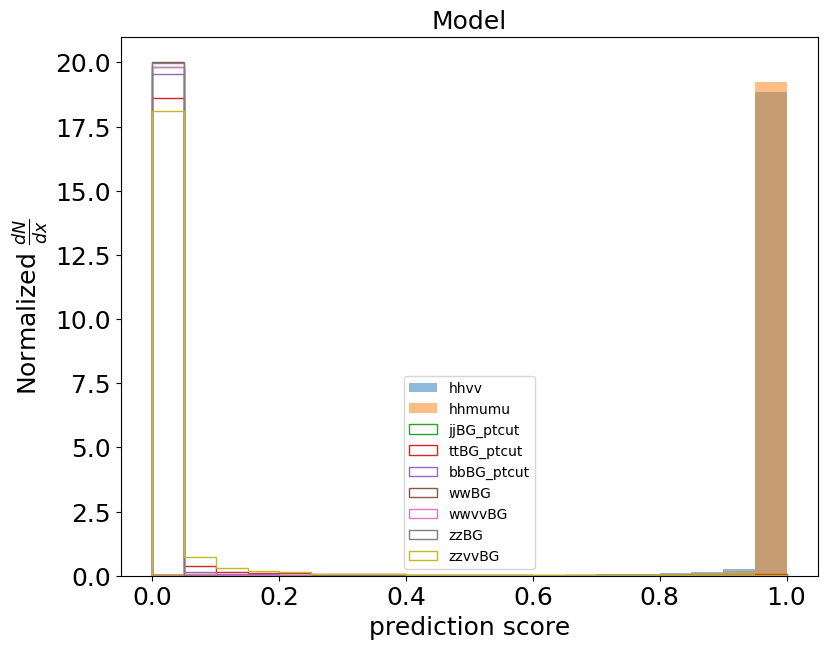

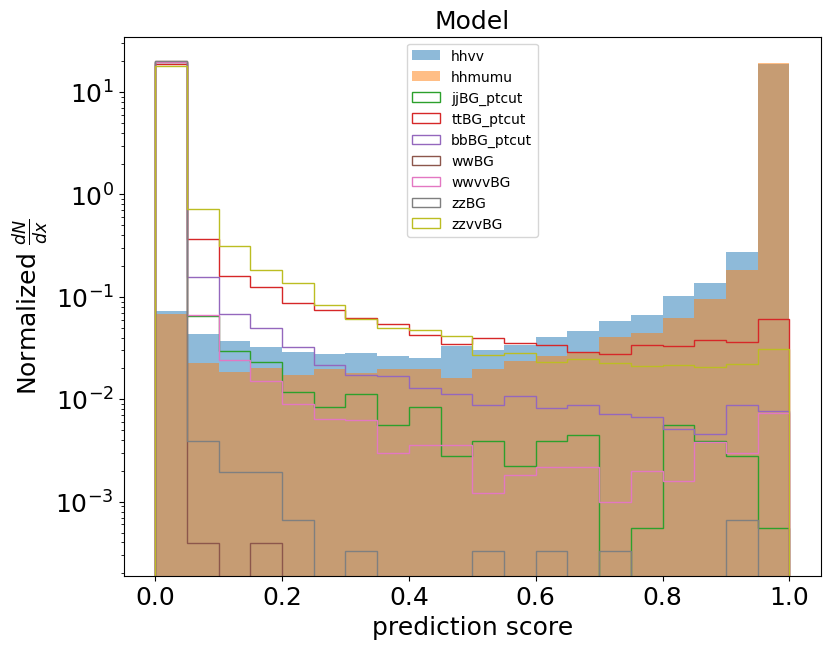

In [22]:
##### plot the prediction histogram #####

plt.figure(1, figsize=(9,7))
bins = np.linspace(0,1,21)
for process in processes:
    plt.hist(prediction[processes.index(process)], bins=bins, label=process, histtype=('stepfilled' if (process=='hhvv' or process=='hhmumu') else 'step'), density=True, alpha=(0.5 if (process=='hhvv' or process=='hhmumu') else 1))
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(r"prediction score", fontsize=18)
plt.ylabel(r"Normalized $\frac{dN}{dx}$", fontsize=18)
# plt.yscale("log")
plt.title("Model", fontsize=18)
plt.legend(loc='best')
plt.show()

plt.figure(1, figsize=(9,7))
bins = np.linspace(0,1,21)
for process in processes:
    plt.hist(prediction[processes.index(process)], bins=bins, label=process, histtype=('stepfilled' if (process=='hhvv' or process=='hhmumu') else 'step'), density=True, alpha=(0.5 if (process=='hhvv' or process=='hhmumu') else 1))
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(r"prediction score", fontsize=18)
plt.ylabel(r"Normalized $\frac{dN}{dx}$", fontsize=18)
plt.yscale("log")
plt.title("Model", fontsize=18)
plt.legend(loc='best')
plt.show()

In [11]:
### Do the score cut ###

score_cuts = [0.5, 0.7, 0.8, 0.9, 0.99, 0.999]

for score_cut in score_cuts:
    print("In score cut", score_cut)

    num_afterML = []
    for process in processes: num_afterML.append(sum(prediction[processes.index(process)]>=score_cut)[0])
    print("Number before ML: ", event_num)
    print("Number after  ML: ", num_afterML)
    
    ### calculate significance ###
    
    s, b = 0, 0
    for process in processes[0:2]:
        s += Luminosity * Xsection[processes.index(process)] * (num_afterML[processes.index(process)]/simulation_num)
    for process in processes[2:]:
        b += Luminosity * Xsection[processes.index(process)] * (num_afterML[processes.index(process)]/simulation_num)
        
    def significance(s,b):
        return np.sqrt(2*((s+b)*np.log(1+s/b)-s))
    
    z = significance(s,b)
    print("signal events:", s)
    print("background events:", b)
    print("significance:", z)
    print("\n")

In score cut 0.5
Number before ML:  [147518, 143791, 35834, 35591, 39064, 50582, 99709, 60870, 120594]
Number after  ML:  [144889, 142068, 50, 656, 149, 0, 131, 5, 1459]
signal events: 12.659973428493599
background events: 30.033366830000002
significance: 2.1710475906998727


In score cut 0.7
Number before ML:  [147518, 143791, 35834, 35591, 39064, 50582, 99709, 60870, 120594]
Number after  ML:  [143773, 141354, 24, 409, 78, 0, 94, 3, 837]
signal events: 12.565042354360802
background events: 17.82170653
significance: 2.7014832735805028


In score cut 0.8
Number before ML:  [147518, 143791, 35834, 35591, 39064, 50582, 99709, 60870, 120594]
Number after  ML:  [142850, 140745, 23, 299, 51, 0, 79, 2, 573]
signal events: 12.486403118724
background events: 12.891830890000001
significance: 3.066667512650673


In score cut 0.9
Number before ML:  [147518, 143791, 35834, 35591, 39064, 50582, 99709, 60870, 120594]
Number after  ML:  [141092, 139617, 6, 172, 32, 0, 52, 2, 320]
signal events: 12.33

high level influence:  0.057109155
low  level influence:  0.054206233


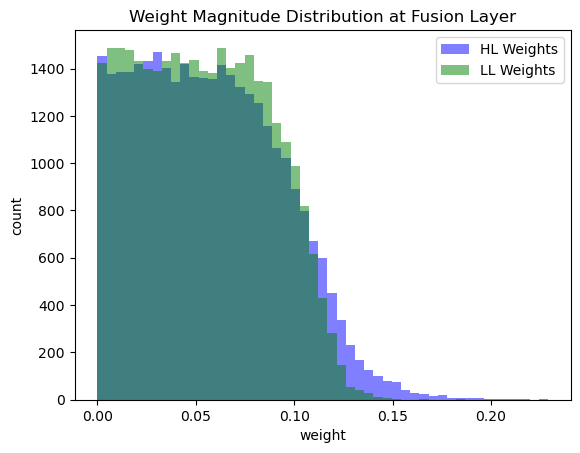

In [20]:
### check which part of model is more important ###

weights, biases = model.get_layer('dense_4').get_weights()
hl_influence = np.mean(np.abs(weights[:128, :]))
ll_influence = np.mean(np.abs(weights[128:, :]))
print("high level influence: ", hl_influence)
print("low  level influence: ", ll_influence)

weights, _ = model.get_layer('dense_4').get_weights()

hl_weights = np.abs(weights[:128, :]).flatten()
ll_weights = np.abs(weights[128:, :]).flatten()

bins = np.linspace(0,max(hl_weights), 50)
plt.hist(hl_weights, bins=bins, alpha=0.5, label='HL Weights', color='blue')
plt.hist(ll_weights, bins=bins, alpha=0.5, label='LL Weights', color='green')
plt.title('Weight Magnitude Distribution at Fusion Layer')
plt.xlabel('weight')
plt.ylabel('count')
plt.legend()
plt.show()

In [13]:
import shap

background_indices = np.random.choice(HL_train.shape[0], 200, replace=False)
background = [HL_train[background_indices], LL_train[background_indices]]

explainer = shap.DeepExplainer(model, background)

test_data = [HL_val, LL_val]
shap_values = explainer.shap_values(test_data)

/root/miniconda3/envs/tf/lib/python3.10/site-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/root/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


In [14]:
hl_importance = np.abs(shap_values[0]).mean()
ll_importance = np.abs(shap_values[1]).mean()

print(f"HL 分支的平均影響力: {hl_importance:.4f}")
print(f"LL 分支的平均影響力: {ll_importance:.4f}")

HL 分支的平均影響力: 0.0380
LL 分支的平均影響力: 0.0013


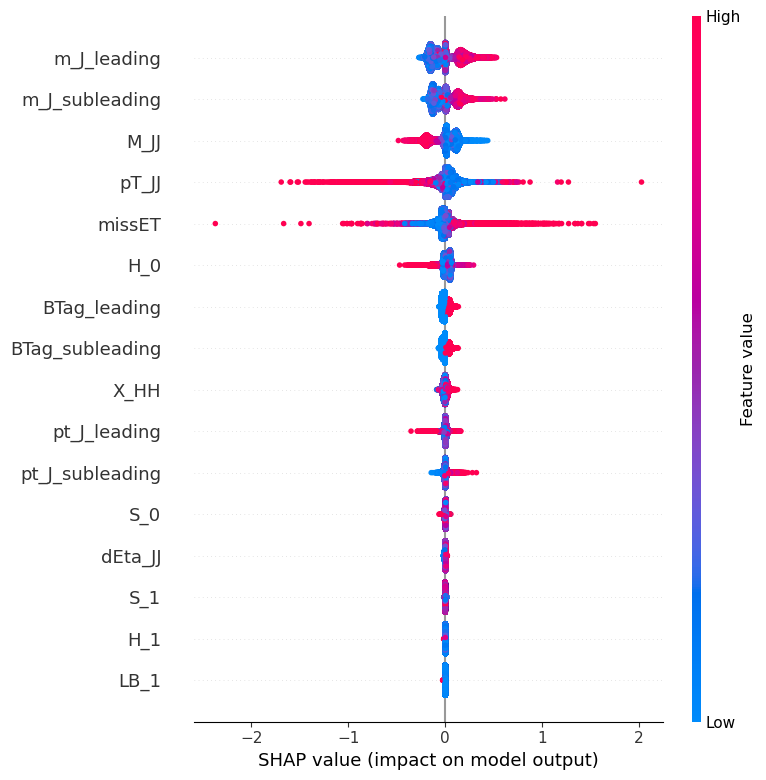

In [15]:
shap.summary_plot(shap_values[0][:,:,0], test_data[0], feature_names=HLfeatures)

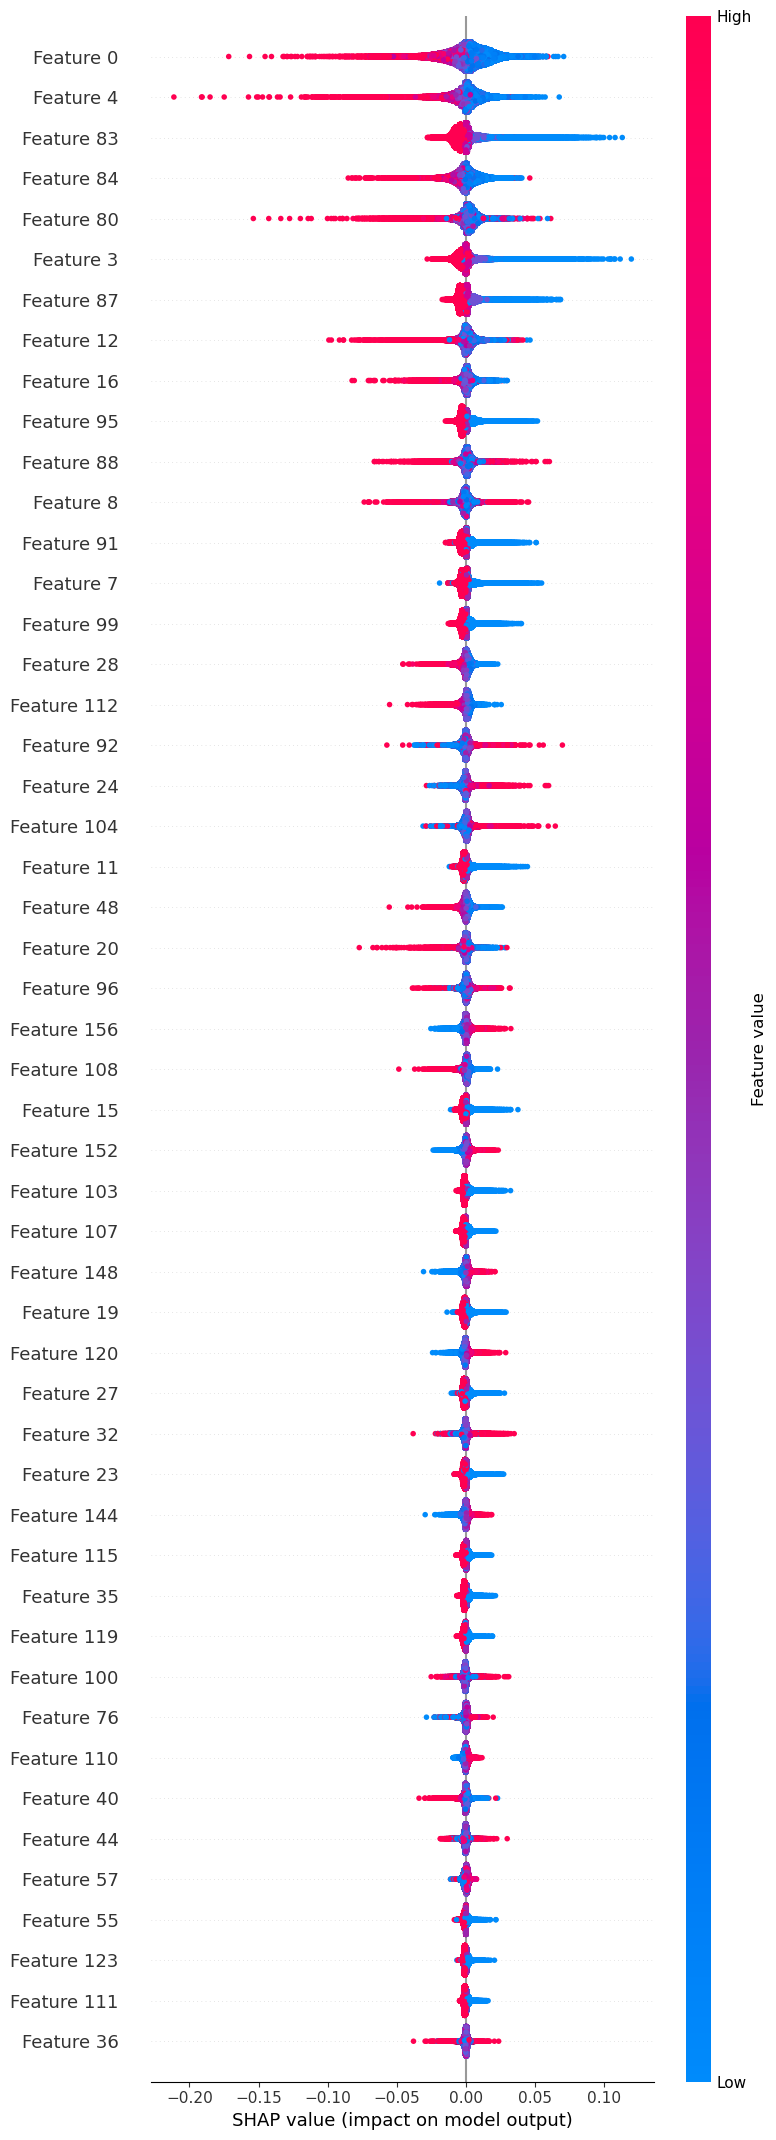

In [16]:
shap.summary_plot(shap_values[1][:,:,0], test_data[1], max_display=50)

In [17]:
print("Time:{:^8.4f}(s)".format(time.time()-t1))

Time:3012.2651(s)
